In [1]:
 %load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


### Import processor

In [4]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [5]:
UsingDaskExecutor = True
CoffeaCasaEnv     = False
load_preexisting  = False    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = True     ### True if run only on one file
load_fit_res      = False

tag = '_L5'

exec('from CoffeaJERCProcessor'+tag+' import Processor') 

add_tag = '_QCD' # '_testing_19UL18' # ''
tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

if load_preexisting == True:
    UsingDaskExecutor = False

In [6]:
## assume running on the LPC
xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
dataset = 'fileNames_QCD20UL18.txt'
# dataset = 'dataset.txt'


rootfiles = open(dataset).read().split()

fileslist = [xrootdstr + file for file in rootfiles]

In [7]:
# to test on one file, uncomment the line below

fileslist = fileslist
if test_run:
    fileslist = [fileslist[0]]
    ### The smallest file in the RunIISummer20UL18NanoAODv9 dataset
#     fileslist = ['root://cms-xrd-global.cern.ch//'+
#                  '/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root']
# fileslist


Test if certificate works opening the file

In [8]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [9]:
import uproot

In [10]:
ff = uproot.open(fileslist[0])
ff.keys()
ff.close()

220810 14:08:26 14959 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:26 14959 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


['tag;1',
 'Events;1',
 'LuminosityBlocks;1',
 'Runs;1',
 'MetaData;1',
 'ParameterSets;1']

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [23]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [24]:
# Dask set up for LPC only 
if(UsingDaskExecutor and not CoffeaCasaEnv):
#     from lpcjobqueue import LPCCondorCluster
#     cluster = LPCCondorCluster()
#     cluster.adapt(minimum=1, maximum=10)
#     client = Client(cluster)
#     client.upload_file('CoffeaJERCProcessor.py')
    
    
    from dask.distributed import Client
#     client=Client()
#     cluster.adapt(minimum=1, maximum=10)
    client = Client()
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')
# client

2022-08-10 14:08:30,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/anpotreb/dask-worker-space/worker-h5v69gvk', purging
2022-08-10 14:08:30,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/anpotreb/dask-worker-space/worker-pghyih67', purging
2022-08-10 14:08:30,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/anpotreb/dask-worker-space/worker-x1i9_qoc', purging
2022-08-10 14:08:30,265 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/anpotreb/dask-worker-space/worker-2rk7j2rv', purging


{'tcp://127.0.0.1:32915': {'status': 'OK'},
 'tcp://127.0.0.1:39135': {'status': 'OK'},
 'tcp://127.0.0.1:39644': {'status': 'OK'},
 'tcp://127.0.0.1:39777': {'status': 'OK'},
 'tcp://127.0.0.1:41985': {'status': 'OK'}}

In [25]:
# dataset_axis = hist.Cat("dataset", "Primary dataset")
# cats_axis = hist.Cat("anacat", "Analysis Category")

# jetpt_axis = hist.Bin("pt", r"$p_T$", ptbins)
# ptresponse_axis = hist.Bin("ptresponse", "RECO / GEN response", 100, 0, 5)
# jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
# jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", etabins)
# jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)

In [26]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

filesets = {'QCD': fileslist}

if not load_preexisting:
    for name,files in filesets.items(): 
        if not UsingDaskExecutor:
            chosen_exec = 'futures'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.iterative_executor,
        #                                        executor=processor.futures_executor,
                                              executor_args={
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
                                                  'workers': 2},
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])
        else:
            chosen_exec = 'dask'
            output = processor.run_uproot_job({name:files},
                                              treename='Events',
                                              processor_instance=Processor(),
                                              executor=processor.dask_executor,
                                              executor_args={
                                                  'client': client,
                                                  'skipbadfiles':False,
                                                  'schema': NanoAODSchema, #BaseSchema
    #                                               'workers': 2
                                              },
                                              chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    util.save(output, outname)
    outputs_unweighted[name] = output
    print(name + ' unweighted output loaded')
else:
    # output = util.load('out/CoffeaJERCOutputs_binned.coffea')
    output = util.load(outname)
    
elapsed = time.time() - tstart

dict_keys(['Summer20UL18_V2_MC_L1FastJet_AK4PFchs', 'Summer20UL18_V2_MC_L2Relative_AK4PFchs', 'Summer20UL18_V2_MC_L3Absolute_AK4PFchs'])
['Summer20UL18_V2_MC_L1FastJet_AK4PFchs', 'Summer20UL18_V2_MC_L2Relative_AK4PFchs', 'Summer20UL18_V2_MC_L3Absolute_AK4PFchs']

[                                        ] | 0% Completed |  0.9s

220810 14:08:33 15200 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:33 15200 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


[                                        ] | 1% Completed |  0.9s7s

220810 14:08:36 15225 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:36 15225 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:36 15238 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:36 15238 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


[                                        ] | 1% Completed |  1.9s

220810 14:08:37 15233 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:37 15243 220810 14:08:37 15233 secgsi_secgsi_InitInit: : Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
220810 14:08:37 15243 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


QCD unweighted output loaded#############] | 100% Completed |  1min  1.6s


### Fit responses

In [27]:
# define gaussian function for fitting the responses
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [28]:
# ptbins = output['ptresponse'].axis('pt').edges()
# ptbins;
# etabins = output['ptresponse'].axis('jeteta').edges()[:-1]
# etabins;

In [29]:
# # jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
# jetpt_length = len(ptbins)
# # jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
# jeteta_length = len(etabins)

# mean = np.zeros((jetpt_length, jeteta_length))
# median = np.zeros((jetpt_length, jeteta_length))
# width = np.zeros((jetpt_length, jeteta_length))
# idx = []

In [30]:
# for k in range(len(etabins)-1):
#     print(hist.Interval(etabins[k], etabins[k+1]))
# print()    
# for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
#     print(etaBin)

Define some global variables for the fit

In [31]:
f_xvals = np.linspace(0,5,5001)
ptbins = output['ptresponse'].axis('pt').edges()
etabins = output['ptresponse'].axis('jeteta').edges()
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]


In [32]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.160

In [33]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 


# xvals = output['ptresponse'+samp].axis('ptresponse').centers()

# FitFigDir = 'fig/response_pt_eta'+samp+tag
# if not os.path.exists(FitFigDir):
#     os.mkdir(FitFigDir)

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')

    mean = np.zeros((jetpt_length, jeteta_length))
    median = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
    chi2s = np.zeros((jetpt_length, jeteta_length))
    meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/response_pt_eta'+samp+tag_full
    print("Images will be saved under ", FitFigDir)
    if not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
    plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
    hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
    plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

    xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,5,5001)


    for i in range(len(ptbins)-1):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
        print('-'*25)
        print('pt bin '+str(ptBin))
        print('-'*25)

        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
            etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
#             etaBin = hist.Interval(etabins[k], etabins[k+1])
            print("etaBin = ", etaBinPl ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBinPl.lo)+'to'+str(etaBinPl.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histoMi = output['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin)
            histoPl = output['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin)
            histo = (histoMi+histoPl)
            histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
            yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

            try:
                p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                N_converge += 1

                            ### Second Gaussian
                xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
                if len(range(xfit_l,xfit_h))<4: #if there are only 3pnts, the uncertainty is infty
                    xfit_l = xfit_l-1
                    xfit_h = xfit_h+1
                    if len(range(xfit_l,xfit_h))<4:
                        xfit_l = xfit_l-1
                        xfit_h = xfit_h+1
                xvals2 = xvals[xfit_l: xfit_h]
                yvals2 = yvals[xfit_l: xfit_h]
                p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                ygaus = gauss(xvals, *p2)
                chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                Ndof = len(xvals2)-3
                if chi2<50000:
                    pass
                    print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
                else:
                    print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
            except:
    #             print("Fit failed because of non-convergance, p = ", p)
                N_not_converge += 1
                continue


#             fgaus = gauss(f_xvals, *p)
            fgaus2 = gauss(f_xvals, *p2)

            median[i,k] = np.median(histvals)
            mean[i,k] = p2[1] # - (scal-1)
            width[i,k] = p2[2]
            chi2s[i,k] = chi2
            meanvar[i,k] = arr[1,1]
#             idx.append(i)

   ####################### Plotting ############################
            if not test_run:
                N = histo.integrate('ptresponse').values()[('QCD',)]
                histo = histo.rebin('ptresponse', plot_response_axis)

                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                h = ax2.get_ylim()[1]/1.05
                plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
                plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
                ax2.legend();

                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
                plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf');
                plt.close();                

    warnings.filterwarnings('default')
    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, width, median, chi2s, meanvar]
    

In [34]:
df_csv = pd.read_csv('out_txt/Closure_L5_QCD.csv').set_index('etaBins')
closure_corr = df_csv.to_numpy().transpose()
closure_corr = np.pad(closure_corr,1,constant_values=1)

In [35]:
ab = np.array([[1,2,3,4,5,10,1], [2,3,2,3,2,3,5]]).transpose()

In [36]:
closure_corr[[1,2,3,4,5,10,1], [2,3,2,3,2,3,5]]


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.67401754, 1.        ])

In [37]:
[0,1,2,3,4,5][:-1]

[0, 1, 2, 3, 4]

In [38]:
etabins_mod

array([0. , 1.3, 2.5, 3. , 5. ])

In [39]:
def plot_corrections(mean, samp, meanvar):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    # h = np.max(histo.values()[('QCD',)])
    fig, ax = plt.subplots()
    start = 17
    
#     etabins_mod = np.flip(etabins[(len(etabins)-1)//2:])
    
#     k1 = np.where(etabins<=-1.3)[0][-1]
    k2 = np.where(etabins_mod<=0)[0][-1]
#     k3 = np.where(etabins<=-2.5)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
#     k5 = np.where(etabins<=-3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
#     k7 = np.where(etabins<=-5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
#     print("mean_p = ", mean_p[start:,k2])
#     print("mean_p = ", mean[start:,k2])

#     print("Shapes = ", ptbins.shape, mean_p.shape, meanvar.shape  )
    
    # ax.plot(ptbins[start:],mean_p[start:,k0], 'o', label=f'${etabins[k0]}<\eta<{etabins[k0+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k1], yerr=np.sqrt(meanvar[start:,k1]), marker='o',
#                  linestyle="none", label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k2], yerr=np.sqrt(meanvar[start:,k2]), marker='o',
                 linestyle="none", label=f'${etabins_mod[k2]}<\eta<{etabins_mod[k2+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k3], yerr=np.sqrt(meanvar[start:,k3]), marker='o',
#                  linestyle="none", label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k4], yerr=np.sqrt(meanvar[start:,k4]), marker='o',
             linestyle="none", label=f'${etabins_mod[k4]}<\eta<{etabins_mod[k4+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k5], yerr=np.sqrt(meanvar[start:,k5]), marker='o',
#                  linestyle="none", label=f'${etabins[k5]}<\eta<{etabins[k5+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k6], yerr=np.sqrt(meanvar[start:,k6]), marker='o',
             linestyle="none", label=f'${etabins_mod[k6]}<\eta<{etabins_mod[k6+1]}$')
#     plt.errorbar(ptbins[start:],mean_p[start:,k7], yerr=np.sqrt(meanvar[start:,k7]), marker='o',
#              linestyle="none", label=f'${etabins[k7]}<\eta<{etabins[k7+1]}$')
    plt.errorbar(ptbins[start:-1],mean_p[start:,k8], yerr=np.sqrt(meanvar[start:,k8]), marker='o',
             linestyle="none", label=f'${etabins_mod[k8]}<\eta<{etabins_mod[k8+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
    # ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
#     print("ynorm = ", y_norm)
#     print("yerr = ", yerr_norm)
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
#     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    ax.set_ylim(0.988 , 1.011)
    
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'mean response');
    ax.set_xscale('log')
    # ax.set_ylim([0.8,1.1])
    ax.legend()
    if test_run:
        plt.savefig('fig//corr_vs_pt'+samp+tag_full+'_test.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'_test.png');
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [40]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
#     return df

In [46]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('before_closure/out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

-------------------------
-------------------------
Fitting subsample:  


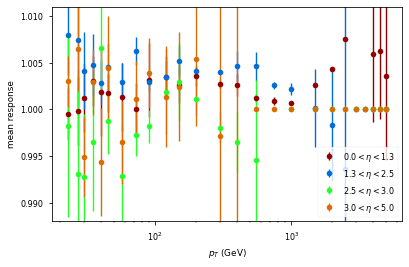

In [48]:
# load_fit_res=True
# subsamples = ['', '_b', '_c', '_l', '_g']
subsamples = ['']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Mean", samp)
        meanvar = read_data("MeanVar", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, width, median, chi2s, meanvar = fit_responses(output, samp)
        for data, name in zip([mean, width, median, meanvar],["Mean", "Width", "Median", "MeanVar"]):
            save_data(data, name, samp)
            
    plot_corrections(mean, samp, meanvar)

In [ ]:
### To scale the histograms to the closure
# scalings = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5_scale.csv').set_index('etaBins')

In [199]:
# import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad 

# N_converge = 0
# N_not_converge = 0
# chi2s = np.zeros((jetpt_length, jeteta_length))
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42]
# hist_pt_edges = plot_pt_edges[1:-1]
# plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

# xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
# # xvals = xvals[1:]
# f_xvals = np.linspace(0,5,5001)

# FitFigDir = 'fig/response_pt_eta'+samp+tag_full
# print("Images will be saved under ", FitFigDir)
# if not os.path.exists(FitFigDir):
#     os.mkdir(FitFigDir)



# for i in range(len(ptbins)-1):
        
#     ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#     print('-'*25)
#     print('pt bin '+str(ptBin))
#     print('-'*25)
    
#     if not 'inf' in str(ptBin):
#         pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
#     else:
#         pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
#         pt_string = pt_string.replace('.0','').replace('-infto','0to')
    
#     for k in range(len(etabins)-1):
        
#         etaBin = hist.Interval(etabins[k], etabins[k+1])
#         eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
#         eta_string = eta_string.replace('.','')
   
#         # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
#         histo = output['ptresponse'+samp].integrate('jeteta', etaBin).integrate('pt', ptBin) 
        
#         histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

#         yvals = histo.values()[('QCD',)][1:]
# #         yvals = yvals
# #         scal = scalings.loc[etaBin.lo,str(ptBin.lo)]
# #         xvals2 = xvals-(scal-1)
        
#         print("etaBin = ", etaBin ,", ptBin = ", ptBin )
        
#         try:
#             p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
#             N_converge += 1
            
            
#                         ### Second Gaussian
#             xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
#             xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
#             xvals2 = xvals[xfit_l: xfit_h]
#             yvals2 = yvals[xfit_l: xfit_h]
#             p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)
            
#             ygaus = gauss(xvals, *p2)
#             chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
#             Ndof = len(xvals)-3
#             if chi2<50000:
#                 pass
#                 print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#             else:
#                 print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )

#         except:
# #             print("Fit failed because of non-convergance, p = ", p)
#             N_not_converge += 1
#             continue
        
        
#         fgaus = gauss(f_xvals, *p)
#         fgaus2 = gauss(f_xvals, *p2)
        
#         median[i,k] = np.median(histvals)
#         mean[i,k] = p[1] # - (scal-1)
#         width[i,k] = p[2]
#         chi2s[i,k] = chi2
#         idx.append(i)
        
#         N = histo.integrate('ptresponse').values()[('QCD',)]
#         histo = histo.rebin('ptresponse', plot_response_axis)

#         if not test_run:
#             h = np.max(histo.values()[('QCD',)]);
#             h = h if h!=0 else 0.05
#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                         fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
#             ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
#             ax2.plot(f_xvals, fgaus2, label='Gaus, 2nd fit',linewidth=1.8)
#             ax2.set_xlabel("JER ($E_{RECO}/E_{GEN}$)")
#             ax2.set_xlim(plot_pt_edges[[0,-1]])
#             plt.text(1.4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
#             plt.text(1.4,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)))
#             plt.text(1.4,0.61*h,'Width {0:0.2f}'.format(p[2]))
#             plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/{0:0.1f}'.format(chi2, Ndof))
#             plt.text(1.3,0.46*h,'N data = {0:0.0f}'.format(N))
#             ax2.legend(ncol=2);
            
# #             hist.plot1d(histo, ax=ax2, overlay='dataset');
# #             ax2.plot(f_xvals, fgaus, label='Gaus');
# #             plt.text(3.8,0.75*h,'Mean {0:0.2f}'.format(p[1]));
# #             plt.text(3.8,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)));
# #             plt.text(3.8,0.61*h,'Width {0:0.2f}'.format(p[2]));
# #             ax2.legend();

#             # plt.show();
#             plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png');
#             plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf');
#             plt.close();                
        
# warnings.filterwarnings('default')
# print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );    

### Playground with fitting and plotting

In [95]:
# scalings.to_numpy()[0,2]

In [96]:
# mean[2,0]

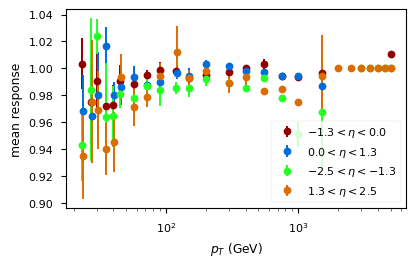

In [269]:

### To ignore the points with 0 on y axis when setting the y axis limits
mean_p = mean.copy()
mean_p[mean_p==0] = np.nan

# h = np.max(histo.values()[('QCD',)])
fig, ax = plt.subplots()
start = 17
k0 = np.where(etabins<=-5)[0][-1]
k4 = np.where(etabins<=-3)[0][-1]
k1 = np.where(etabins<=-2.5)[0][-1]
k5 = np.where(etabins<=-1.3)[0][-1]
k2 = np.where(etabins<=0)[0][-1]
k3 = np.where(etabins<=1.3)[0][-1]


# ax.plot(ptbins[start:],mean_p[start:,k0], 'o', label=f'${etabins[k0]}<\eta<{etabins[k0+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k4], 'o', label=f'${etabins[k4]}<\eta<{etabins[k4+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k1], 'o', label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
plt.errorbar(ptbins[start:],mean_p[start:,k5], yerr=np.sqrt(meanvar[start:,k5]), marker='o',
             linestyle="none", label=f'${etabins[k5]}<\eta<{etabins[k5+1]}$')
plt.errorbar(ptbins[start:]+0.4,mean_p[start:,k2], yerr=np.sqrt(meanvar[start:,k2]), marker='o',
             linestyle="none", label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')

plt.errorbar(ptbins[start:],mean_p[start:,k1], yerr=np.sqrt(meanvar[start:,k1]), marker='o',
             linestyle="none", label=f'${etabins[k1]}<\eta<{etabins[k1+1]}$')
plt.errorbar(ptbins[start:]+0.4,mean_p[start:,k3], yerr=np.sqrt(meanvar[start:,k3]), marker='o',
             linestyle="none", label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')
# plt.errorbar(ptbins[start:],mean_p[start:,k3], yerr=np.sqrt(meanvar[start:,k3]), marker='o',
#              linestyle="none", label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k5], 'o', label=f'${etabins[k5]}<\eta<{etabins[k5+1]}$')

# ax.plot(ptbins[start:],mean_p[start:,k2], 'o', label=f'${etabins[k2]}<\eta<{etabins[k2+1]}$')
# ax.plot(ptbins[start:],mean_p[start:,k3], 'o', label=f'${etabins[k3]}<\eta<{etabins[k3+1]}$')

ax.set_xlabel(r'$p_T$ (GeV)');
ax.set_ylabel(r'mean response');
ax.set_xscale('log')
# ax.set_ylim([0.8,1.1])
ax.legend(loc='lower right')
# if test_run:
#     plt.savefig('fig/corr_vs_pt'+samp+tag_full+'_test.pdf');
# else:
#     plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');

plt.show();

### Fit a specific $\eta$ $p_T$ bin

In [317]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)

Images will be saved under  fig/response_pt_eta_L5_QCD


In [391]:
ptbins

array([1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00, 5.0e+00, 6.0e+00, 7.0e+00,
       8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01, 1.2e+01, 1.3e+01, 1.4e+01,
       1.5e+01, 1.7e+01, 2.0e+01, 2.3e+01, 2.7e+01, 3.0e+01, 3.5e+01,
       4.0e+01, 4.5e+01, 5.7e+01, 7.2e+01, 9.0e+01, 1.2e+02, 1.5e+02,
       2.0e+02, 3.0e+02, 4.0e+02, 5.5e+02, 7.5e+02, 1.0e+03, 1.5e+03,
       2.0e+03, 2.5e+03, 3.0e+03, 3.5e+03, 4.0e+03, 4.5e+03, 5.0e+03,
       1.0e+04])

In [516]:
# histo = output['ptresponse'].integrate('jeteta', hist.Interval(-2.5, -1.3)).integrate('pt', hist.Interval(300, 350))
histoMi = output['ptresponse_b'+samp].integrate('jeteta', hist.Interval(-3.0, -2.5)).integrate('pt', hist.Interval(11, 12))
histoPl = output['ptresponse_b'+samp].integrate('jeteta', hist.Interval(2.5, 3.0)).integrate('pt', hist.Interval(11, 12))
histo = (histoMi+histoPl)
histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
N_converge += 1

            ### Second Gaussian
xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]-1
xfit_h = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0][0]
if len(range(xfit_l,xfit_h))<5: #if there are only 3pnts, the uncertainty is infty
#     print(len(range(xfit_l,xfit_h)))
    xfit_l = xfit_l-1
    xfit_h = xfit_h+1
    if len(range(xfit_l,xfit_h))<5:
#         print(len(range(xfit_l,xfit_h)))
        xfit_l = xfit_l-1
        xfit_h = xfit_h+1
xvals2 = xvals[xfit_l: xfit_h]
yvals2 = yvals[xfit_l: xfit_h]
# p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

ygaus = gauss(xvals, *p2)
chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
Ndof = len(xvals2)-3
if chi2<50000:
    pass
    print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
else:
    print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
#             print("Fit failed because of non-convergance, p = ", p)


fgaus = gauss(f_xvals, *p)
fgaus2 = gauss(f_xvals, *p2)

histo.values()[('QCD',)][:-1]
N = histo.integrate('ptresponse').values()[('QCD',)]
histo = histo.rebin('ptresponse', plot_response_axis)


Fit failed because of high chi2, p =  [8.55247816 1.63012268 0.28794495] , chi2 =  24241679199.88787


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 8., 8., 6., 5., 3., 5., 6.,
       3., 4., 3., 1., 4., 6., 1., 3., 2., 1., 0., 2., 0., 0., 0., 2., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<>:12: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \c
<>:12: DeprecationWarning: invalid escape sequence \p
<>:13: DeprecationWarning: invalid escape sequence \p
<>:15: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_22787/1377357775.py:12: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
/tmp/anpotreb/ipykernel_22787/1377357775.py:13: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
/tmp/anpotreb/ipykernel_22787/1377357775.py:15: DeprecationWarning: invalid escape sequence \c
  plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))


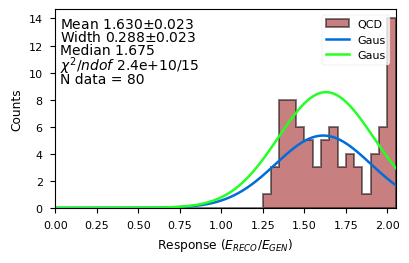

In [521]:


# h = np.max(histo.values()[('QCD',)][:-1]);
# h = h if h!=0 else 0.05
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
# ax2.set_ylim(0,h)
plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
ax2.legend();


In [522]:
xvals2

array([1.175, 1.225, 1.275, 1.325, 1.375, 1.425, 1.475, 1.525, 1.575,
       1.625, 1.675, 1.725, 1.775, 1.825, 1.875, 1.925, 1.975, 2.025])

<>:13: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \p
<>:16: DeprecationWarning: invalid escape sequence \c
<>:13: DeprecationWarning: invalid escape sequence \p
<>:14: DeprecationWarning: invalid escape sequence \p
<>:16: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_22787/3758398721.py:13: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
/tmp/anpotreb/ipykernel_22787/3758398721.py:14: DeprecationWarning: invalid escape sequence \p
  plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
/tmp/anpotreb/ipykernel_22787/3758398721.py:16: DeprecationWarning: invalid escape sequence \c
  plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))


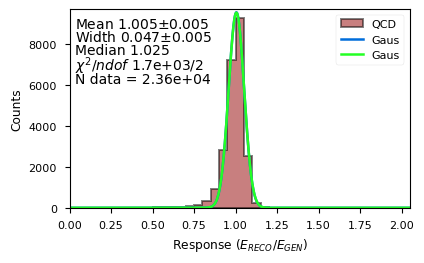

In [389]:
# N = histo.integrate('ptresponse').values()[('QCD',)]
# histo = histo.rebin('ptresponse', plot_response_axis)

h = np.max(yvals[:-1]);
h = h if h!=0 else 0.05
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
plt.text(0.03,0.95*h,'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1],np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,'Width {0:0.3f}$\pm${1:0.3f}'.format(p2[2],np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,'Median {0:0.3f}'.format(np.median(histvals)))
plt.text(0.03,0.73*h,'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,'N data = {0:0.3g}'.format(N))
ax2.legend();


<>:10: DeprecationWarning: invalid escape sequence \c
<>:10: DeprecationWarning: invalid escape sequence \c
/tmp/anpotreb/ipykernel_22787/380541488.py:10: DeprecationWarning: invalid escape sequence \c
  plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/97'.format(chi2))


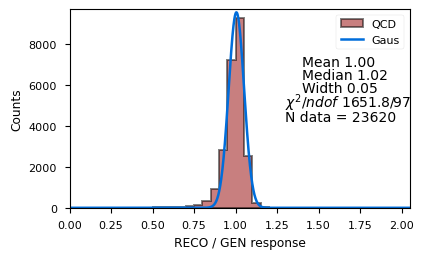

In [390]:
all# %%capture
fig, ax2 = plt.subplots()
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.set_xlim(plot_pt_edges[[0,-1]])
plt.text(1.4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
plt.text(1.4,0.68*h,'Median {0:0.2f}'.format(np.median(histvals)))
plt.text(1.4,0.61*h,'Width {0:0.2f}'.format(p[2]))
plt.text(1.3,0.53*h,'$\chi^2/ndof$ {0:0.1f}/97'.format(chi2))
plt.text(1.3,0.46*h,'N data = {0:0.0f}'.format(N))
ax2.legend();

plt.show();
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.png');
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.eps');
# plt.savefig('fig/ptResponse_test'+pt_string+eta_string+'.pdf');
plt.close();

### Save fit data to csv's

### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [270]:
# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')

In [39]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_csv)